In this notebook, we will generate arbitary partition

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

### arbitary partition 16x9

In [23]:
def set_good_gemo_pos(xyes):
    xes,yes = xyes.transpose(1,0)
    for now_value,another_value in [[14,-2],[15,-1],[-1,15],[-2,14]]:
        if now_value in xes:
            x_rest    = xes[xes!=now_value]
            if len(x_rest)==0:break
            mean_value = x_rest.mean()
            if abs(mean_value-another_value) < abs(mean_value-now_value):
                xes[np.where(xes==now_value)[0]]=another_value
    return np.stack([xes,yes],-1)

##### generate json file

In [26]:
from models.arbitary_shape.shapes_list import *
import numpy as np

In [25]:
def generate_json_map_for_16x9_cylinder(shape_block):
    def iterl(x):
        return x%16

    info_per_point = {}
    info_per_group = {}
    for i,line in enumerate(shape_block):
        for j,val in enumerate(line):
            info_per_point[(i,j)] = {'val':val}
    def search_for(pos,group=None):
        i,j = pos
        pos =  iterl(i),j
        val = info_per_point[pos]['val']
        if 'group' not in info_per_point[pos]:
            if group is None:group=len(info_per_group)
            info_per_point[pos]['group']=group
            if group not in info_per_group:info_per_group[group]={'element':[],'neighbor':set()}
            info_per_group[group]['element'].append((pos[0],pos[1]))#element should be the topology idx, it will count in further work
            for gemo_neighbor in [(i-1,j),(i+1,j),(i,j-1),(i,j+1)]: 
                neighbor = iterl(gemo_neighbor[0]),gemo_neighbor[1]
                if (neighbor in info_per_point):
                    neighbor_val = info_per_point[neighbor]['val']
                    if ('group' not in info_per_point[neighbor]) and (val == neighbor_val):
                        search_for(gemo_neighbor,group)

    for i,line in enumerate(shape_block):
        for j,val in enumerate(line):
            search_for((i,j))

    info_per_line={}
    for i,line in enumerate(shape_block):
        for j,val in enumerate(line):
            group_now = info_per_point[(i,j)]['group']
            for gemo_neighbor in [(i-1,j),(i+1,j),(i,j-1),(i,j+1)]:
                neighbor = iterl(gemo_neighbor[0]),gemo_neighbor[1]
                if neighbor in info_per_point:
                    neighbor_group = info_per_point[neighbor]['group']
                    if neighbor_group!=group_now:
                        info_per_group[group_now]['neighbor']=info_per_group[group_now]['neighbor']|set([neighbor_group])
                        line_tuple = [group_now,neighbor_group]
                        line_tuple.sort() 
                        line_tuple= tuple(line_tuple)
                        if line_tuple not in info_per_line:info_per_line[line_tuple]={"element":[]}
                        #print(gemo_neighbor)
                        linepos=[(i,j),neighbor]# the line from (i,j) to the neighbor (a,b)
                        linepos.sort() 
                        if linepos not in info_per_line[line_tuple]["element"]:
                            info_per_line[line_tuple]["element"].append(linepos)
                        if abs(neighbor[0]-i)>16//2:
                            #print(f"({i},{j})->({neighbor[0]},{neighbor[1]})")
                            info_per_line[line_tuple]["type"]="arc"
                        else:
                            info_per_line[line_tuple]["type"]="line"


    W,H = np.array(shape_block).shape 
    center = np.array([8,4]) 
    for line,pool in info_per_line.items():
        start_pos=np.array([a for a,b in pool['element']])
        ended_pos=np.array([b for a,b in pool['element']])

        start_pos=set_good_gemo_pos(start_pos)
        ended_pos=set_good_gemo_pos(ended_pos)

        start_pos=np.mean(start_pos,0)# if contine (16,j) node then redirect to (0,j) so cause wrong
        ended_pos=np.mean(ended_pos,0)
        distance = (np.linalg.norm(start_pos-center) + np.linalg.norm(ended_pos-center))/2
        centr_pos=(start_pos+ended_pos)/2
        info_per_line[line]['weight']    = distance
        info_per_line[line]['start_pos'] = list(start_pos)
        info_per_line[line]['ended_pos'] = list(ended_pos)
        info_per_line[line]['centr_pos'] = list(centr_pos)
        #print(f"line:{line} {start_pos}->{ended_pos} centr:{centr_pos} distance:{distance}")

    ##### calculate D according to the distance to center.

    MAX_Dimension = 10
    MIN_Dimension = 3
    weight_list  = [val['weight'] for val in info_per_line.values()]
    max_distance = max(weight_list)
    min_distance = min(weight_list)
    Dimenstion_function = lambda x : np.floor((MIN_Dimension-MAX_Dimension)/(max_distance-min_distance)*(x-min_distance)+MAX_Dimension)

    for line,pool in info_per_line.items():
        info_per_line[line]['D']    = Dimenstion_function(info_per_line[line]['weight'])

    for group in info_per_group.keys():
        info_per_group[group]['neighbor']=list(info_per_group[group]['neighbor'])

    for group,info in info_per_group.items():
        info_per_group[group]['element_idx']=np.ravel_multi_index(np.array(info['element']).transpose(),(W,H)).tolist()
        info_per_group[group]['element_x']  =np.array(info['element']).transpose()
        info_per_group[group]['element_y']  =np.array(info['element']).transpose()

    import torch

    arbitary_shape_state_dict={}
    arbitary_shape_state_dict['node']   =info_per_group
    arbitary_shape_state_dict['line']   =info_per_line
    arbitary_shape_state_dict['element']=info_per_point
    return arbitary_shape_state_dict

In [32]:
patch_info = generate_json_map_for_16x9_cylinder(shape_16x9_12)

In [33]:
#torch.save(patch_info,"models/arbitary_shape/arbitary_shape_16x9_12.json")

###### generate a list patch

In [6]:
import numpy as np
import torch

In [25]:
all_partion=[]
for i in range(8):
    if i>1:continue
    for j in range(i+1,8):
        if j -i>4:continue
        for k in range(j+1,8):
            if k-j>4:continue
            if 7-k>1:continue
            all_partion.append([i,j,k])
def create_patch_map(column_partition,row_partion=[0,3,6,9]):
    group = 1
    x,y,z =  column_partition
    ll = np.zeros((16,9))
    for s,e in zip(row_partion[:-1],row_partion[1:]):
        idx= np.arange(-x,x+1)
        ll[idx,s:e] = group;group+=1
    for s,e in zip(row_partion[:-1],row_partion[1:]):
        ll[x+1:y+1,s:e]   = group;group+=1
        ll[16-y:16-x,s:e] = group;group+=1
    for s,e in zip(row_partion[:-1],row_partion[1:]):
        ll[y+1:z+1,s:e]   = group;group+=1
        ll[16-z:16-y,s:e] = group;group+=1
    for s,e in zip(row_partion[:-1],row_partion[1:]):
        idx= np.arange(z+1,16-z)
        ll[idx,s:e] = group;group+=1    
    return ll
# row_partition = [0,3,6,9]
# patch_partions_list      = [create_patch_map(t,row_partition) for t in all_partion]
# patch_partions_json_list = [generate_json_map_for_16x9_cylinder(t) for t in patch_partions_list]
# torch.save(patch_partions_json_list,f"models/arbitary_shape/patch_partions_3column_{len(all_partion)}units.pt")
# row_partition = [0,2,4,5,7,9]
# patch_partions_list      = [create_patch_map(t,row_partition) for t in all_partion]
# patch_partions_json_list = [generate_json_map_for_16x9_cylinder(t) for t in patch_partions_list]
# torch.save(patch_partions_json_list,f"models/arbitary_shape/patch_partions_5column_{len(all_partion)}units.pt")

In [35]:
# ##### old # for 19 outputs
# all_partion=[]
# for i in range(9):
#     if i>2:continue
#     for j in range(i+2,9):
#         if j -i>4:continue
#         for k in range(j+2,9):
#             if k-j>4:continue
#             if 8-k>2:continue
#             all_partion.append([i,j,k])
# def create_patch_map(column_partition,row_partion=[0,3,6,9]):
#     group = 1
#     x,y,z =  column_partition
#     ll = np.zeros((16,9))
#     for s,e in zip(row_partion[:-1],row_partion[1:]):
#         idx= np.arange(-x,x+1)
#         ll[idx,s:e] = group;group+=1
#     for s,e in zip(row_partion[:-1],row_partion[1:]):
#         ll[x+1:y+1,s:e]   = group;group+=1
#         ll[16-y:16-x,s:e] = group;group+=1
#     for s,e in zip(row_partion[:-1],row_partion[1:]):
#         ll[y+1:z+1,s:e]   = group;group+=1
#         ll[16-z:16-y,s:e] = group;group+=1
#     for s,e in zip(row_partion[:-1],row_partion[1:]):
#         idx= np.arange(z,16-z+1)
#         ll[idx,s:e] = group;group+=1    
#     return ll
# row_partition = [0,3,6,9]
# patch_partions_list = [create_patch_map(t,row_partition) for t in all_partion]
# patch_partions_json_list = [generate_json_map_for_16x9_cylinder(t) for t in patch_partions_list]
# torch.save(patch_partions_json_list,"models/arbitary_shape/patch_partions_3colum_max45raw_json_list_regen.pt")

In [37]:
i=5
print(all_partion[i])
create_patch_map(all_partion[i],[0,3,6,9])

[0, 4, 8]


array([[ 1.,  1.,  1.,  2.,  2.,  2.,  3.,  3.,  3.],
       [ 4.,  4.,  4.,  6.,  6.,  6.,  8.,  8.,  8.],
       [ 4.,  4.,  4.,  6.,  6.,  6.,  8.,  8.,  8.],
       [ 4.,  4.,  4.,  6.,  6.,  6.,  8.,  8.,  8.],
       [ 4.,  4.,  4.,  6.,  6.,  6.,  8.,  8.,  8.],
       [10., 10., 10., 12., 12., 12., 14., 14., 14.],
       [10., 10., 10., 12., 12., 12., 14., 14., 14.],
       [10., 10., 10., 12., 12., 12., 14., 14., 14.],
       [16., 16., 16., 17., 17., 17., 18., 18., 18.],
       [11., 11., 11., 13., 13., 13., 15., 15., 15.],
       [11., 11., 11., 13., 13., 13., 15., 15., 15.],
       [11., 11., 11., 13., 13., 13., 15., 15., 15.],
       [ 5.,  5.,  5.,  7.,  7.,  7.,  9.,  9.,  9.],
       [ 5.,  5.,  5.,  7.,  7.,  7.,  9.,  9.,  9.],
       [ 5.,  5.,  5.,  7.,  7.,  7.,  9.,  9.,  9.],
       [ 5.,  5.,  5.,  7.,  7.,  7.,  9.,  9.,  9.]])

# plot

In [1]:
import numpy as np
import plotly.graph_objects as go
import numpy as np
import torch

###### 3D plot

In [9]:
# x_max = 16
# radius= 3
# def to_cylinder_coor(x,y):
#     theta = 2*np.pi*x/x_max
#     return theta,y
# def cylinder(theta_start,theta_end, h_start,h_end, nt=2, nv =2):
#     """
#     parametrize the cylinder of radius r, height h, base point a
#     """
#     theta    = np.linspace(theta_start, theta_end, nt)
#     v        = np.linspace(h_start, h_end, nv )
#     theta, v = np.meshgrid(theta, v)
#     x        = radius*np.cos(theta)
#     y        = radius*np.sin(theta)
#     z        = v
#     return x, y, z

# arbitary_shape_state_dict = torch.load("F:\\server\\SUTD Office\\Tensor_Network_Project\\models\\arbitary_shape\\arbitary_shape_16x9_2.json")
# info_per_group = arbitary_shape_state_dict['node']
# info_per_line  = arbitary_shape_state_dict['line']
# info_per_point = arbitary_shape_state_dict['element']
# objects = []
# offsite = 0.5
# scalar  = 4
# radius=3

# objects=[]
# alpha=0.3
# for (g_l,g_r), pool in info_per_line.items():
#     start_pos=pool['start_pos']
#     ended_pos=pool['ended_pos']
#     line_type = pool["type"] if "type" in pool else "line"
#     D = pool['D']
#     xes = np.array([start_pos[0],ended_pos[0]])
#     yes = np.array([start_pos[1],ended_pos[1]])

#     theta0,z0 = to_cylinder_coor(xes,yes)
#     x0,y0 = radius*np.cos(theta0),radius*np.sin(theta0)
#     objects.append(go.Scatter3d(x=x0, y=y0, z=z0,mode='lines',line=dict(color='firebrick', width=4)))
    
# for idx,(group, pool) in enumerate(info_per_group.items()):
    
#     xes,yes=np.array(pool['element']).transpose()
#     xes = (1-2*alpha)*(xes - min(xes)) + min(xes) + alpha*(max(xes)-min(xes))
#     yes = (1-2*alpha)*(yes - min(yes)) + min(yes) + alpha*(max(yes)-min(yes))
# #    h = max(yes)-min(yes)
# #     c_x = xes.mean()
# #     c_y = yes.mean()
# #     x0  = scalar*min(xes)-offsite
# #     x1  = scalar*max(xes)+offsite
# #     z0  = scalar*min(yes)-offsite
# #     z1  = scalar*max(yes)+offsite
#     theta0,z0 = to_cylinder_coor(xes,yes)
#     x0,y0 = radius*np.cos(theta0),radius*np.sin(theta0)
#     objects.append(go.Scatter3d(x=x0, y=y0, z=z0,mode='markers',marker=dict(
#                                             size=12,
#                                             color=idx,                # set color to an array/list of desired values
#                                             colorscale='Viridis',   # choose a colorscale
#                                             opacity=1
#                                         )))
# axis = dict(showline=False, zeroline=False,showgrid=False,showticklabels=False,)
# fig.update_layout(showlegend=False,scene = dict(xaxis = axis,yaxis = axis,zaxis = axis),plot_bgcolor='white')

# fig = go.Figure()
# for obj in objects:
#     fig.add_trace(obj)
# fig

###### 2D plot rectangle

In [53]:
def ellipse_arc2(start_point=0, end_point=0, start_angle=0, end_angle=2*np.pi, N=100, closed= False):
    a = (end_point[0] - start_point[0])/(np.cos(end_angle)-np.cos(start_angle))
    if end_point[1] == start_point[1]:# 这并不是一个通用方案
        b = 2
    else:
        b = (end_point[1] - start_point[1])/(np.sin(end_angle)-np.sin(start_angle))
    x_center = end_point[0] - a*np.cos(end_angle)
    y_center = end_point[1] - b*np.sin(end_angle)
    t = np.linspace(start_angle, end_angle, N)
    x = x_center + a*np.cos(t)
    y = y_center + b*np.sin(t)
    return x,y    

In [4]:
# arbitary_shape_state_dict = torch.load("models/arbitary_shape/arbitary_shape_16x9_2.json")
# info_per_group = arbitary_shape_state_dict['node']
# info_per_line  = arbitary_shape_state_dict['line']
# info_per_point = arbitary_shape_state_dict['element']

In [23]:
# #### plot######
# objects = []
# offsite = 0.5
# scalar  = 4
# for (g_l,g_r), pool in info_per_line.items():
#     start_pos=pool['start_pos']
#     ended_pos=pool['ended_pos']
#     line_type = pool["type"] if "type" in pool else "line"
#     D = pool['D']
#     x0,y0  = scalar*np.array(start_pos)
#     x1,y1  = scalar*np.array(ended_pos)
#     if line_type == "line":
#         objects.append(go.Scatter(x=[x0,x1],y=[y0,y1],mode='lines', fill="toself",
#                               text=f"D={D}",hoveron='points',hoverinfo='text'
#                                  )
#                       )
#     else:
#         x,y = ellipse_arc2(start_point=[x0,y0], end_point=[x1,y1], start_angle=np.pi+1/6*np.pi, 
#                            end_angle=-1/6*np.pi,  N=60)
#         objects.append(go.Scatter(x=x,y=y,mode='lines',# fill="toself",
#                               text=f"D={D}",hoveron='points',hoverinfo='text'
#                                  )
#                       )
                    

# for group, pool in info_per_group.items():
#     xes,yes=np.array(pool['element']).transpose()
#     w = max(xes)-min(xes)
#     h = max(yes)-min(yes)
#     c_x = xes.mean()
#     c_y = yes.mean()
#     x0  = scalar*min(xes)-offsite
#     x1  = scalar*max(xes)+offsite
#     y0  = scalar*min(yes)-offsite
#     y1  = scalar*max(yes)+offsite
#     objects.append(go.Scatter(x=[x0,x0,x1,x1,x0],y=[y0,y1,y1,y0,y0],mode='lines',fill="toself",
#                                hoveron='fills',hoverinfo='text',text=f"G={group}",
#                               ))




# fig = go.Figure()

# axis = dict(showline=False, zeroline=False,showgrid=False,showticklabels=False,)
# fig.update_layout(showlegend=False,xaxis=axis,yaxis=axis,plot_bgcolor='white')
# fig.update_layout(
#          autosize=False,
#             width=800,
#             height=800,
#         hoverlabel=dict(
#         bgcolor="white",
#         font_size=16,
#         font_family="Rockwell"
#         )
# )
# fig.update_xaxes(fixedrange=True)
# fig.update_yaxes(scaleanchor = "x",scaleratio = 1,)
# #if show_name: self.depoly_label(fig)
# for obj in objects:fig.add_trace(obj)
# fig

In [54]:
def plot_partition(partition_path):
    arbitary_shape_state_dict = torch.load(partition_path)
    info_per_group = arbitary_shape_state_dict['node']
    info_per_line  = arbitary_shape_state_dict['line']
    info_per_point = arbitary_shape_state_dict['element']
    
    objects = []
    offsite = 0.5
    scalar  = 4
    for (g_l,g_r), pool in info_per_line.items():
        start_pos=pool['start_pos']
        ended_pos=pool['ended_pos']
        line_type = pool["type"] if "type" in pool else "line"
        D = pool['D']
        x0,y0  = scalar*np.array(start_pos)
        x1,y1  = scalar*np.array(ended_pos)
        if line_type == "line":
            objects.append(go.Scatter(x=[x0,x1],y=[y0,y1],mode='lines', fill="toself",
                                  text=f"D={D}",hoveron='points',hoverinfo='text'
                                     )
                          )
        else:
            x,y = ellipse_arc2(start_point=[x0,y0], end_point=[x1,y1], start_angle=np.pi+1/6*np.pi, 
                               end_angle=-1/6*np.pi,  N=60)
            objects.append(go.Scatter(x=x,y=y,mode='lines',# fill="toself",
                                  text=f"D={D}",hoveron='points',hoverinfo='text'
                                     )
                          )


    for group, pool in info_per_group.items():
        xes,yes=np.array(pool['element']).transpose()
        w = max(xes)-min(xes)
        h = max(yes)-min(yes)
        c_x = xes.mean()
        c_y = yes.mean()
        x0  = scalar*min(xes)-offsite
        x1  = scalar*max(xes)+offsite
        y0  = scalar*min(yes)-offsite
        y1  = scalar*max(yes)+offsite
        objects.append(go.Scatter(x=[x0,x0,x1,x1,x0],y=[y0,y1,y1,y0,y0],mode='lines',fill="toself",
                                   hoveron='fills',hoverinfo='text',text=f"G={group}",
                                  ))




    fig = go.Figure()

    axis = dict(showline=False, zeroline=False,showgrid=False,showticklabels=False,)
    fig.update_layout(showlegend=False,xaxis=axis,yaxis=axis,plot_bgcolor='white')
    fig.update_layout(
             autosize=False,
                width=800,
                height=800,
            hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell"
            )
    )
    fig.update_xaxes(fixedrange=True)
    fig.update_yaxes(scaleanchor = "x",scaleratio = 1,)
    #if show_name: self.depoly_label(fig)
    for obj in objects:fig.add_trace(obj)
    return fig

In [3]:
# plot_partition("models/arbitary_shape/arbitary_shape_16x9_6.json")

In [23]:
matrix=[]
for i in range(24):
    line=[]
    for j in range(24):
        line.append(info_per_point[i,j]['group'])
    matrix.append(line)
matrix = np.array(matrix)   

KeyError: (0, 9)

In [38]:
from mltool.visualization import *

TypeError: Image data of dtype object cannot be converted to float

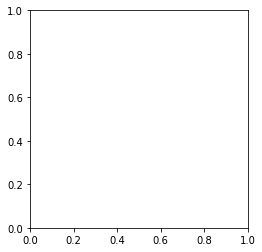

In [39]:
%matplotlib inline
plt.imshow(np.array(matrix))

###### 2D plot polar

In [3]:
############# function
import plotly.colors
from PIL import ImageColor
def get_color(colorscale_name, loc):
    from _plotly_utils.basevalidators import ColorscaleValidator
    # first parameter: Name of the property being validated
    # second parameter: a string, doesn't really matter in our use case
    cv = ColorscaleValidator("colorscale", "")
    # colorscale will be a list of lists: [[loc1, "rgb1"], [loc2, "rgb2"], ...] 
    colorscale = cv.validate_coerce(colorscale_name)
    
    if hasattr(loc, "__iter__"):
        return [get_continuous_color(colorscale, x) for x in loc]
    return get_continuous_color(colorscale, loc)
def get_continuous_color(colorscale, intermed):
    """
    Plotly continuous colorscales assign colors to the range [0, 1]. This function computes the intermediate
    color for any value in that range.

    Plotly doesn't make the colorscales directly accessible in a common format.
    Some are ready to use:
    
        colorscale = plotly.colors.PLOTLY_SCALES["Greens"]

    Others are just swatches that need to be constructed into a colorscale:

        viridis_colors, scale = plotly.colors.convert_colors_to_same_type(plotly.colors.sequential.Viridis)
        colorscale = plotly.colors.make_colorscale(viridis_colors, scale=scale)

    :param colorscale: A plotly continuous colorscale defined with RGB string colors.
    :param intermed: value in the range [0, 1]
    :return: color in rgb string format
    :rtype: str
    """
    if len(colorscale) < 1:
        raise ValueError("colorscale must have at least one color")

    hex_to_rgb = lambda c: "rgb" + str(ImageColor.getcolor(c, "RGB"))

    if intermed <= 0 or len(colorscale) == 1:
        c = colorscale[0][1]
        return c if c[0] != "#" else hex_to_rgb(c)
    if intermed >= 1:
        c = colorscale[-1][1]
        return c if c[0] != "#" else hex_to_rgb(c)

    for cutoff, color in colorscale:
        if intermed > cutoff:
            low_cutoff, low_color = cutoff, color
        else:
            high_cutoff, high_color = cutoff, color
            break

    if (low_color[0] == "#") or (high_color[0] == "#"):
        # some color scale names (such as cividis) returns:
        # [[loc1, "hex1"], [loc2, "hex2"], ...]
        low_color = hex_to_rgb(low_color)
        high_color = hex_to_rgb(high_color)

    return plotly.colors.find_intermediate_color(
        lowcolor=low_color,
        highcolor=high_color,
        intermed=((intermed - low_cutoff) / (high_cutoff - low_cutoff)),
        colortype="rgb",
    )

In [4]:
def to_circle_coor(x,y):
    theta = 2*np.pi/(x_max-x_min)*(x-x_min) + x_min
    radius= (radius_max-radius_min)/(y_max-y_min)*(y-y_min)+radius_min
    return radius*np.cos(theta),radius*np.sin(theta)

def to_circle_coor2(x,y):
    theta = 2*np.pi/(x_max-x_min)*(x-x_min) + x_min
    radius= (radius_max-radius_min)/(y_max-y_min)*(y-y_min)+radius_min
    
    thetamin = min(theta)
    thetamax = max(theta)
    if (thetamax - thetamin) > np.pi:
        thetamax = -thetamax 
    radiusmin= min(radius)
    radiusmax= max(radius)
    
    p0=[[t,radiusmin] for t in np.linspace(thetamin,thetamax,100)]
    p1=[[thetamax,radiusmin]]
    p2=[[thetamax,radiusmax]]
    p3=[[t,radiusmax] for t in np.linspace(thetamax,thetamin,100)] 
    p4=[[thetamin,radiusmin]]
    ps=p0+p1+p2+p3+p4
    xes,yes = np.array(ps).transpose(1,0)
    return yes*np.cos(xes),yes*np.sin(xes)

In [5]:
radius_min = 2
radius_max = 10
x_max      = 16
x_min      = 0
y_max      = 9
y_min      = 0


In [35]:
# #########
#arbitary_shape_state_dict = torch.load("models/arbitary_shape/arbitary_shape_16x9_7.json")
# info_per_group = arbitary_shape_state_dict['node']
# info_per_line  = arbitary_shape_state_dict['line']
# info_per_point = arbitary_shape_state_dict['element']
# objects = []
# offsite = 0.2
# scalar  = 1
# ### add line
# for (g_l,g_r), pool in info_per_line.items():
#     start_pos=pool['start_pos']
#     ended_pos=pool['ended_pos']
#     line_type = pool["type"] if "type" in pool else "line"
#     D = pool['D']
#     xes     = np.array([start_pos[0],ended_pos[0]])
#     yes     = np.array([start_pos[1],ended_pos[1]])
#     xes,yes = to_circle_coor2(xes,yes)

#     objects.append(go.Scatter(x=xes,y=yes,mode='lines', line=dict(color="#000000",width=4),
#                                   text=f"D={D}",hoveron='points',hoverinfo='text',opacity=1
#                                  )
#                       )


# ### add block
# for idx,(group, pool) in enumerate(info_per_group.items()):
#     xes,yes=set_good_gemo_pos(np.array(pool['element'])).transpose()
   
#     #xes,yes=np.array(pool['element']).transpose()
    
#     w = max(xes)-min(xes)
#     h = max(yes)-min(yes)
#     c_x = xes.mean()
#     c_y = yes.mean()
#     x0  = scalar*min(xes)-offsite
#     x1  = scalar*max(xes)+offsite
#     y0  = scalar*min(yes)-offsite
#     y1  = scalar*max(yes)+offsite
#     xes = np.array([x0,x0,x1,x1,x0])
#     yes = np.array([y0,y1,y1,y0,y0])
#     xes,yes = to_circle_coor2(xes,yes)
#     color = get_color('Viridis',((min(xes)+max(xes))/2+radius_max)/(4*radius_max)+
#                                 (abs(min(yes)+max(yes))/2)/(2*radius_max))
#     objects.append(go.Scatter(x=xes,y=yes,mode='lines', line=dict(color=color,width=1),
#                                   fill='tozeroy', 
#                                   fillcolor=color,
#                               hoveron='fills',hoverinfo='text',text=f"G={group}",opacity=1
#                               ))


# fig = go.Figure()

# axis = dict(showline=False, zeroline=False,showgrid=False,showticklabels=False,)
# fig.update_layout(showlegend=False,xaxis=axis,yaxis=axis,plot_bgcolor='white')
# fig.update_layout(
#          autosize=False,
#             width=800,
#             height=800,
#         hoverlabel=dict(
#         bgcolor="white",
#         font_size=16,
#         font_family="Rockwell"
#         )
# )
# fig.update_xaxes(fixedrange=True)
# fig.update_yaxes(scaleanchor = "x",scaleratio = 1,)
# #if show_name: self.depoly_label(fig)
# for obj in objects:fig.add_trace(obj)
# fig

In [6]:
def plot_partition_polar(partition_path):
    if isinstance(partition_path,str):
        arbitary_shape_state_dict = torch.load(partition_path)
    else:
        arbitary_shape_state_dict=partition_path
    #########

    info_per_group = arbitary_shape_state_dict['node']
    info_per_line  = arbitary_shape_state_dict['line']
    info_per_point = arbitary_shape_state_dict['element']
    objects = []
    offsite = 0.2
    scalar  = 1
    ### add line
    for (g_l,g_r), pool in info_per_line.items():
        start_pos=pool['start_pos']
        ended_pos=pool['ended_pos']
        line_type = pool["type"] if "type" in pool else "line"
        D = pool['D']
        xes     = np.array([start_pos[0],ended_pos[0]])
        yes     = np.array([start_pos[1],ended_pos[1]])
        xes,yes = to_circle_coor2(xes,yes)

        objects.append(go.Scatter(x=xes,y=yes,mode='lines', line=dict(color="#000000",width=4),
                                      text=f"D={D}",hoveron='points',hoverinfo='text',opacity=1
                                     )
                          )


    ### add block
    for idx,(group, pool) in enumerate(info_per_group.items()):
        xes,yes=set_good_gemo_pos(np.array(pool['element'])).transpose()

        #xes,yes=np.array(pool['element']).transpose()

        w = max(xes)-min(xes)
        h = max(yes)-min(yes)
        c_x = xes.mean()
        c_y = yes.mean()
        x0  = scalar*min(xes)-offsite
        x1  = scalar*max(xes)+offsite
        y0  = scalar*min(yes)-offsite
        y1  = scalar*max(yes)+offsite
        xes = np.array([x0,x0,x1,x1,x0])
        yes = np.array([y0,y1,y1,y0,y0])
        xes,yes = to_circle_coor2(xes,yes)
        color = get_color('Viridis',((min(xes)+max(xes))/2+radius_max)/(4*radius_max)+
                                    (abs(min(yes)+max(yes))/2)/(2*radius_max))
        objects.append(go.Scatter(x=xes,y=yes,mode='lines', line=dict(color=color,width=1),
                                      fill='tozeroy', 
                                      fillcolor=color,
                                  hoveron='fills',hoverinfo='text',text=f"G={group}",opacity=1
                                  ))


    fig = go.Figure()

    axis = dict(showline=False, zeroline=False,showgrid=False,showticklabels=False,)
    fig.update_layout(showlegend=False,xaxis=axis,yaxis=axis,plot_bgcolor='white')
    fig.update_layout(
             autosize=False,
                width=800,
                height=800,
            hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell"
            )
    )
    fig.update_xaxes(fixedrange=True)
    fig.update_yaxes(scaleanchor = "x",scaleratio = 1,)
    #if show_name: self.depoly_label(fig)
    for obj in objects:fig.add_trace(obj)
    return fig

In [2]:
# plot_partition_polar("models/arbitary_shape/arbitary_shape_16x9_13.json")

In [39]:
patch_partions_list = torch.load("models/arbitary_shape/patch_partions_5colum_max45raw_json_list.pt")
len(patch_partions_list)

19

In [1]:
# for idx,t in enumerate(patch_partions_list):
#     print(idx)
#     fig=plot_partition_polar(t)
#     fig.show()
# #fig.write_image("figures/arbitary_shape_16x9_10.png")

In [9]:
#fig.write_image("figures/arbitary_shape_16x9_2.png")